In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob 
#from skimage.io import imread #read images from files
import os
import cv2 
from PIL import Image
from keras_unet_collection import models
import matplotlib.pyplot as plt # plt show image
import matplotlib.image as mpimg # mpimg read image
import tensorflow as tf

In [3]:
from keras_unet_collection.layer_utils import *
from keras_unet_collection.activations import GELU, Snake
from keras_unet_collection.transformer_layers import patch_extract, patch_embedding
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, MultiHeadAttention, LayerNormalization, Dense, Embedding
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


def ViT_MLP(X, filter_num, activation='GELU', name='MLP'):
    '''
    The MLP block of ViT.
    
    ----------
    Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, 
    T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S. and Uszkoreit, J., 2020. 
    An image is worth 16x16 words: Transformers for image recognition at scale. 
    arXiv preprint arXiv:2010.11929.
    
    Input
    ----------
        X: the input tensor of MLP, i.e., after MSA and skip connections
        filter_num: a list that defines the number of nodes for each MLP layer.
                        For the last MLP layer, its number of node must equal to the dimension of key.
        activation: activation of MLP nodes.
        name: prefix of the created keras layers.
        
    Output
    ----------
        V: output tensor.
    '''
    activation_func = eval(activation)
    
    for i, f in enumerate(filter_num):
        X = Dense(f, name='{}_dense_{}'.format(name, i))(X)
        X = activation_func(name='{}_activation_{}'.format(name, i))(X)
        
    return X

def ViT_block(V, num_heads, key_dim, filter_num_MLP, activation='GELU', name='ViT'):
    '''
    
    Vision transformer (ViT) block.
    
    ViT_block(V, num_heads, key_dim, filter_num_MLP, activation='GELU', name='ViT')
    
    ----------
    Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, 
    T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S. and Uszkoreit, J., 2020. 
    An image is worth 16x16 words: Transformers for image recognition at scale. 
    arXiv preprint arXiv:2010.11929.
    
    Input
    ----------
        V: embedded input features.
        num_heads: number of attention heads.
        key_dim: dimension of the attention key (equals to the embeded dimensions).
        filter_num_MLP: a list that defines the number of nodes for each MLP layer.
                        For the last MLP layer, its number of node must equal to the dimension of key.
        activation: activation of MLP nodes.
        name: prefix of the created keras layers.
        
    Output
    ----------
        V: output tensor.
    
    '''
    # Multiheaded self-attention (MSA)
    V_atten = V # <--- skip
    V_atten = LayerNormalization(name='{}_layer_norm_1'.format(name))(V_atten)
    V_atten = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, 
                                 name='{}_atten'.format(name))(V_atten, V_atten)
    # Skip connection
    V_add = add([V_atten, V], name='{}_skip_1'.format(name)) # <--- skip
    
    # MLP
    V_MLP = V_add # <--- skip
    V_MLP = LayerNormalization(name='{}_layer_norm_2'.format(name))(V_MLP)
    V_MLP = ViT_MLP(V_MLP, filter_num_MLP, activation, name='{}_mlp'.format(name))
    # Skip connection
    V_out = add([V_MLP, V_add], name='{}_skip_2'.format(name)) # <--- skip
    
    return V_out

In [4]:
def count_area(image):
     (cnts, _) = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
     c = sorted(cnts, key=cv2.contourArea, reverse=True)

     for nb in range(0,len(c)):
         area=cv2.contourArea(cnts[nb]);
         #print(area)
     return(area)
            
def count_number(image):
     (cnts, _) = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
     c = sorted(cnts, key=cv2.contourArea, reverse=True)
     return(len(c))
    
def normalize(inp):
    inp = inp.astype('float32')/255.
    mean = np.mean(inp)
    std = np.std(inp)
    return (inp - mean)/std

In [5]:
input_shape = (224, 224, 3)
img_input = Input(shape=input_shape)

# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
# Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

patch_size=1
x = patch_extract((patch_size, patch_size))(x)
x = patch_embedding(49, 128)(x)
filter_num_MLP = [32, 128]
num_transformer=4
name='trans'
for i in range(num_transformer):
    x = ViT_block(x, 12, 128, filter_num_MLP, activation='GELU',
                 name='{}_ViT_{}'.format(name, i))
x = Flatten()(x)  
x = Dense(256, activation='elu', name='fc1')(x)  
x = Dropout(0.5)(x) 


predictions = Dense(1, activation='sigmoid', name='predictions')(x) 
classifier = Model(img_input, predictions)  
classifier.load_weights('Shape_classification.hdf5')

In [6]:
from keras_unet_collection import models
segmenter = models.transunet_2d((224, 224, 1), filter_num=[16, 32, 64, 128, 256, 512], n_labels=1, stack_num_down=2, stack_num_up=2,
                                embed_dim=192, num_mlp=768, num_heads=12, num_transformer=12,
                                activation='ReLU', mlp_activation='GELU', output_activation='Sigmoid', 
                                batch_norm=True, pool=True, unpool='bilinear', name='transunet')

segmenter.load_weights('Fine_segmentation.hdf5')

In [7]:
#############################Fine segmentation

In [8]:
prediction_path='E:/ziheng-projects/test_jerome/segmentation/data/aLatest/Global/test/prediction/04.28/3SpatialAug/prediction/'
file_list = os.listdir(prediction_path)


for file in file_list: # get path
    print(file)
    cur_path = os.path.join(prediction_path, file)
    image = np.array(cv2.imread(cur_path))


1.png
121.png
122.png
2.png
3.png
34.png
35.png


In [14]:
def loop(prediction_path,new_path):
    file_list = os.listdir(prediction_path)
    final_masks=[]
    num_crops=0
    outlier=0
    for file in file_list: # get path
        #print(file)
        cur_path = os.path.join(prediction_path, file)
        image = np.array(cv2.imread(cur_path))

        crops = []
        size = 224

        cnts, _ = cv2.findContours(image[...,0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for c in cnts:
            x,y,w,h = cv2.boundingRect(c)
            crop = image[y:y+h,x:x+w].copy()
            
            left_size = (size - crop.shape[1]) // 2
            right_size = size - crop.shape[1] - left_size
            top_size = (size-crop.shape[0]) // 2
            bottom_size = size - crop.shape[0] - top_size

            crop = cv2.copyMakeBorder(crop, top_size, bottom_size, left_size, right_size, cv2.BORDER_CONSTANT, value=0)
            crops.append(((x,y,w,h), crop))
        num_crops=num_crops+len(crops)
        out_image = np.zeros_like(image, dtype='float32')
        for (x,y,w,h), crop in crops:
            #crop = crop.astype('float32')
            crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
            number_before=count_number(crop)            
            if count_area(crop)>29:
                crop = cv2.cvtColor(crop,cv2.COLOR_GRAY2RGB)
                crop = np.expand_dims(crop, axis=0)
                p = classifier(crop).numpy().item()
                if p > 0.5:
                    crop = normalize(crop[...,0])
                    crop = segmenter(crop).numpy()
                    t=0.99
                    crop = (crop > t).astype('uint8')
                    number_after=count_number(crop.squeeze())
                    if number_before==number_after:
                        #print(number_after)
                        outlier+=1
                    crop = np.repeat(crop, 3, axis=-1)
                else:
                    crop = crop/255.

                crop = crop.squeeze()
                x_tmp = (size - w) // 2
                y_tmp = (size - h) // 2
            else: 
                crop = cv2.cvtColor(crop,cv2.COLOR_GRAY2RGB)
                crop=np.zeros_like(crop, dtype='float32')
                x_tmp = (size - w) // 2
                y_tmp = (size - h) // 2
                
            out_image[y:y+h, x:x+w] += crop[y_tmp:y_tmp+h, x_tmp:x_tmp+w]

        out_image = (out_image > 0).astype('uint8')
        #cv2.imwrite(new_path+file,out_image*255)
        final_masks.append(out_image*255)
    return outlier

In [15]:
number_crops=[]
final_masks=[]

new_path='E:/ziheng-projects/final_mask_transUnet/'

outlier=loop(prediction_path,new_path)
print(outlier)

11


In [16]:
def instance_segmentation_metrics_sparse(y, pred, t1=0.99, t2=0.5):#t1 for binalization, t2=threshold
    """
        Computes the IoU based on sparse representation of masks : store coordinates of non-zero elemnts rather than whole image
    """
    
    def IoU_sparse(m1, m2):
        intersection = len(m1.intersection(m2))
        union = len(m1.union(m2))
        return intersection / union
    
    def get_sparse_masks(b):
        contours, _ = cv2.findContours(b, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        masks = []
        for contour in contours:
            m = cv2.drawContours(np.zeros_like(b), [contour], contourIdx=-1, color=1, thickness=-1)
            m = set([tuple(c) for c in np.argwhere(m)])
            masks.append(m)

        return masks

    tp, fp, fn = 0, 0, 0
    
    # binarize the images
    y = (y > t1).astype('uint8').squeeze()
    pred = (pred > t1).astype('uint8').squeeze()
        
    # get binary mask of objects
    y_masks = get_sparse_masks(y)
    pred_masks = get_sparse_masks(pred)
    
    # if no object in prediction, stop
    if len(pred_masks) == 0:
        return 0, 0, 0, len(y_masks)
    
    # if more objects in ground-truth, add FN
    if len(y_masks) > len(pred_masks):
        fn += len(y_masks) - len(pred_masks)
    
    # if more objects in prediction, add FP
    if len(pred_masks) > len(y_masks):
        fp += len(pred_masks) - len(y_masks)

    # computes IoU for every pair of objects in ground-truth and prediction
    all_IoU = []
    for m1 in y_masks:
        for m2 in pred_masks:
            all_IoU.append(IoU_sparse(m1, m2))

    # create list with pairs : ((ground-truth object ID, prediction object ID), IoU)
    i, j = np.meshgrid(range(len(y_masks)), range(len(pred_masks)), indexing='ij')
    pos = np.stack((i, j), axis=-1)
    pos = np.reshape(pos, (-1, 2))
    pos_and_iou = [(p, iou) for p, iou in zip(pos, all_IoU)]
    
    # sort list with decreasing IoU
    pos_and_iou = sorted(pos_and_iou, key=lambda tup: tup[1], reverse=True)
    
    y_selected = []
    pred_selected = []
    IOU = []

    # iterate over sorted list, and pair ground-truth and prediction objects ID if not already paired
    for (y_id, pred_id), p in pos_and_iou:
        if y_id not in y_selected and pred_id not in pred_selected:
            y_selected.append(y_id)
            pred_selected.append(pred_id)
            IOU.append(p)
            
            # if we have used all ground-truth or prediction objects, stop
            if len(y_selected) == len(y_masks) or len(pred_selected) == len(pred_masks):
                break
                
    # for every IoU, if IoU greater than threshold then account for TP, otherwise account for FP and FN
    for i in IOU:
        if i > t2:
            tp += 1
        else:
            fp += 1
            fn += 1
    
    # average precision
    ap = tp / (tp + fp + fn)
    
    return ap, tp, fp, fn



In [17]:
    def Fill_hole(image):
       img1=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
       cnts, hierarchy = cv2.findContours(img1, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)
       c = sorted(cnts, key=cv2.contourArea, reverse=True)
       im_rgb = cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB)
       #print(hierarchy)
        
       for i in range(0,len(c)):
           cv2.drawContours(im_rgb, [c[i]], 0, (255, 255, 255), cv2.FILLED) 


       return im_rgb

In [18]:
import numpy as np
import cv2
import os

if __name__ == '__main__':
    Path = 'E:/ziheng-projects/final_mask_transUnet/'
    gt_path = 'E:/ziheng-projects/test_jerome/segmentation/data/aLatest/Global/validation/mask/'
    FileList = os.listdir(Path)
    gt_list = []
    predit_list = []
    for predit_name in FileList:
        gt_name = predit_name#.split('.png')[0] + '_GT.png'
        gt_img=cv2.imread(gt_path + gt_name, cv2.IMREAD_GRAYSCALE)/255.
        
        pred_img=cv2.imread(Path + predit_name)
        #pred_img=cv2.resize(pred_img, (2048, 2048))
        pred_img=Fill_hole(pred_img)
        pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2GRAY)/255.
       # kernel = np.ones((30, 30), np.uint8)
        #erosion = cv2.dilate(pred_img, kernel, iterations=1)
        gt_list.append(gt_img)
        predit_list.append(pred_img)
    print("Data were loaded")
    taus = [0.5, 0.6, 0.7, 0.8, 0.9]
    AP=[]
    TP=[]
    FP = []
    FN = []
    M=[]
    length=len(gt_list)
    for threshold in taus:
        tp_sum=0
        fp_sum=0
        fn_sum=0
        ap_sum=0
        #print('stop')
        for list in range(length):
            ap, tp, fp, fn =instance_segmentation_metrics_sparse(gt_list[list],predit_list[list],t1=0.5,t2=threshold)
            tp_sum=tp_sum+tp
            fp_sum=fp_sum+fp
            fn_sum=fn_sum+fn
            ap_sum=ap_sum+ap
            #print('stop0')
        TP.append(tp_sum)
        FN.append(fn_sum)
        FP.append(fp_sum)
        AP.append(tp_sum/(tp_sum+fn_sum+fp_sum))
        #print('stop1')
    t=0
    print("theshold: 0."+str(t+5))
    print('TP: '+str(TP[t]))
    print('FN: '+str(FN[t]))
    print('FP: '+str(FP[t]))



    t=1
    print("theshold: 0."+str(t+5))
    print('TP: '+str(TP[t]))
    print('FN: '+str(FN[t]))
    print('FP: '+str(FP[t]))



    t=2
    print("theshold: 0."+str(t+5))
    print('TP: '+str(TP[t]))
    print('FN: '+str(FN[t]))
    print('FP: '+str(FP[t]))



    t=3
    print("theshold: 0."+str(t+5))
    print('TP: '+str(TP[t]))
    print('FN: '+str(FN[t]))
    print('FP: '+str(FP[t]))


    
    t=4
    print("theshold: 0."+str(t+5))
    print('TP: '+str(TP[t]))
    print('FN: '+str(FN[t]))
    print('FP: '+str(FP[t]))



    #print('stop2')
    M.append(TP)
    M.append(FN)
    M.append(FP)
    #print('stop3')


Data were loaded
theshold: 0.5
TP: 498
FN: 91
FP: 89
theshold: 0.6
TP: 462
FN: 127
FP: 125
theshold: 0.7
TP: 371
FN: 218
FP: 216
theshold: 0.8
TP: 171
FN: 418
FP: 416
theshold: 0.9
TP: 4
FN: 585
FP: 583


In [21]:
#with 0.99
print(AP) 

[0.7345132743362832, 0.6470588235294118, 0.4608695652173913, 0.1701492537313433, 0.0034129692832764505]


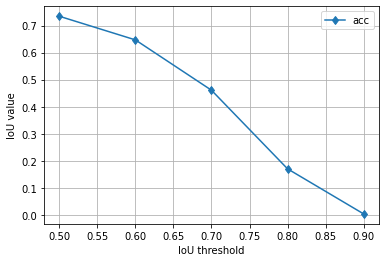

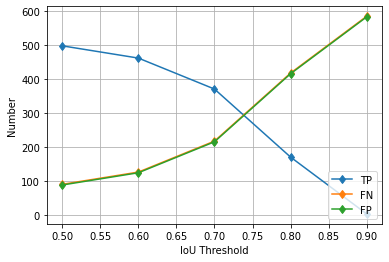

In [22]:
    #new image 
    from PIL import Image
    import matplotlib.pyplot as plt
    plt.figure(1)
    plt.plot(taus,AP,marker='d')
    plt.grid()

    #plt.title('IoU')
    plt.ylabel('IoU value')
    plt.xlabel('IoU threshold')
    plt.legend(['acc'], loc='upper right')

    plt.figure(2)
    for m in M:
     plt.plot(taus,m,marker='d')
     plt.grid()

     #plt.title('The number of TP, FN and FP')
     plt.ylabel('Number')
     plt.xlabel('IoU Threshold')
    plt.legend(['TP','FN','FP'], loc='lower right')
    plt.show()